In [21]:
import pickle
import sys
from sklearn.cluster import KMeans
sys.path.append('/home/ardelalegre/SoundMapping/Analysis/Util')
from get_time_interval_matrix_data import get_time_interval_matrix_data
from PCA import get_cdata
from PCA import get_eigen_vectors
from PCA import project_to_eigen_vectors
from Plot import plot_data
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [346]:
# Calibrated recording timestamp within each minute (based on array 5)
calibrated_time = [['05','41'],
                   ['00','40'],
                   ['01','40'],
                   ['01','38'],
                   ['01','40']]

# # Calibrated recording timestamp within each minute (based on array 5)
# calibrated_time = [['05','41'],
#                    ['00','40'],
#                    ['01','40'],
#                    ['01','38'],
#                    ['01','40'],
#                    ['04','42'],
#                    ['03','44'],
#                    ['01','40'],
#                    ['01','40'],
#                    ['01','40']]

In [347]:
def extractMinuteData(i,calibrated_time):
    """Input: int, index of minute, ranging from 0 to 9
       Output: numpy array, relevant data corr. to minute"""
    
    format_timestring = '%b %d %Y %I:%M:%S%p' # setting format of input time
    start_timestring  = 'Sep 30 2020 11:1' + str(i) + ':' + calibrated_time[i][0] + 'AM' # setting start time
    end_timestring    = 'Sep 30 2020 11:1' + str(i) + ':' + calibrated_time[i][1] + 'AM' # setting end time
    start_standard_dt_string = datetime.datetime.strptime(start_timestring, format_timestring) # converting start time into datetime
    end_standard_dt_string = datetime.datetime.strptime(end_timestring, format_timestring) # converting end time into datetime object

    # given the starting and ending timestamps, we map them to indices of the data

    for x in range(experiment_data.shape[0]):
        if(experiment_data[x,0] > datetime.datetime.timestamp(start_standard_dt_string) and experiment_data[x,0] < datetime.datetime.timestamp(end_standard_dt_string)):
            start_index = x
            break
    for y in range(x,experiment_data.shape[0]):
        if(experiment_data[y,0] > datetime.datetime.timestamp(end_standard_dt_string)):
            end_index = y
            break

    # given the range of indices which correspond to the input time, we extract the relevant data from
    # first_three_projections and returning
    relevant_data_minute = proj_exp_data[x:y]
    
    return relevant_data_minute

In [378]:
def find_center_kmeans(minute_array,n_clusters=20):
    kmeans = KMeans(n_clusters, random_state=0).fit(minute_array)
    unique, counts = numpy.unique(kmeans.labels_, return_counts=True)
    ind = np.argmax(counts)
    minute_mean = kmeans.cluster_centers_[ind]
    return minute_mean

### Step 1: Train model on 29th and 30th September

In [348]:
training_data = get_time_interval_matrix_data('Sep 29 2020 11:00AM', 'Sep 30 2020 05:00PM')

KeyboardInterrupt: 

In [3]:
eigen_values_2930, eigen_vectors_2930 = get_eigen_vectors(training_data)

/home/ardelalegre/SoundMapping/Analysis/Util/PCA.py:44: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data[:,1:],axis = 0,keepdims = True)


In [388]:
import pickle
with open ("model_2930.pk","wb") as pk:
    pickle.dump({"eigenvalues":eigen_values_2930,"eigenvectors":eigen_vectors_2930},pk)

### Step 2: Extract 10 points experiment data from recent 10 point experiment. 

In [349]:
# For simplicity, the first 10 points are extracted
experiment_data = get_time_interval_matrix_data('Sep 30 2020 11:10AM', 'Sep 30 2020 11:15AM')
experiment_cdata = get_cdata(experiment_data)

/home/ardelalegre/SoundMapping/Analysis/Util/PCA.py:44: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data[:,1:],axis = 0,keepdims = True)


### Step 3: Project this data onto the eigenvectors just trained.

In [350]:
# d is the number of PCA dimension we choose to train our model with
d = 4
proj_exp_data = project_to_eigen_vectors(experiment_cdata, d, eigen_values_2930, eigen_vectors_2930)

Take time averages: each row is a position in the PCA space. For the first 40 seconds of each minute, we want just one row.

In [351]:
print("The projected data is of shape", proj_exp_data.shape,"and the experiment data is of the shape", experiment_data.shape)

The projected data is of shape (34346, 4) and the experiment data is of the shape (34346, 19)


Make a list of numpy arrays that store the projections of each minute

In [352]:
minute_arrays = [] 
for i in range(0,5): # where i is minute
    one_minute_data = extractMinuteData(i,calibrated_time)
    minute_arrays.append(one_minute_data)

In [353]:
# kmeans = KMeans(2, random_state=0).fit(minute_arrays[9])
# unique, counts = numpy.unique(kmeans.labels_, return_counts=True)
# unique, counts

### Step 4: Use k-means to find the mean of the cluster that has the most points

In [355]:
minute_mean_array_np = np.asarray([find_center_kmeans(data) for data in minute_arrays])

Findings: in Audacity, for the first and the second minute, a couple arrays did not have recordings due to unknown reasons, and thus data matrix are filled with nans. The third to fifth minute are filled with recordings. When applied K-means on data from each minute, the number of points in each cluster (2 are used) is very distinct from 3rd minute onwards

### Step 5: Obtain physical (x, y) positions of all points 0 to 9

In [356]:
p_0 = [0,0]
p_1 = [1.2,-0.6]
p_2 = [0,-0.6]
p_3 = [-1.2,-0.6]
p_4 = [1.2,0.6]
p_5 = [0,0.6]
p_6 = [-1.2,0.6]
p_7 = [1.2,1.8]
p_8 = [0,1.8]
p_9 = [-1.2,1.8]

list_phys_all_pt_coords = [p_0, p_1, p_2, p_3, p_4, p_5, p_6, p_7, p_8, p_9]

In [357]:
phys_all_pt_coords = np.asarray(list_phys_all_pt_coords)
# print(phys_all_pt_coords)

### Step 6: Affine transformation
### Setup

* Room coordinates : $\vec{r}_i$ for $i=1:n$ $\vec{r}_i \in R^2$
* PCA coordinates : $\vec{v}_i$ for $i=1:n$ $\vec{v}_i \in R^{18}$

We choose $d$ the number of PCA coordinates to use. Probably $d=2,3$

We want an affine transformation which can be described by a matrix and a shoft vector.

$\vec{r} = \vec{s} + M \vec{v}$  where $\vec{s}$ is a 2 dimensional shift, and $M$ is a $2 \times d$ matrix

We can add a coordinate equal to $1$ to the vector $\vec{v}$ (call it $\vec{w}$) and add a column equal to $\vec{s}$ to the matrix $M$ (call is $G$)

Now we have an expressions of the form 

$ \vec{r}_i = G \vec{w}_i$

### Solving

The $2(d+1)$ entries of $G$ the unknowns.

If $2(d+1) > n$ then we have an under-constrained system (there is an infinite number of solutions)

Define the regularization term $\|G\|$ as the sum of the squares of all entries in $G$.

If $2(d+1) < n$ then there is no solution (in general).

We can replace the equalities $ \vec{r}_i = G \vec{w}_i$ by an error:
$$\sum_i \| \vec{r}_i - G \vec{w}_i\|_2^2 $$

Combining this with the regularization term, we get

$$err(G) = \sum_i \| \vec{r}_i - G \vec{w}_i \|_2^2 + \|G\|$$ 

and our goal is to find $G$ with the minimal error.

$$
G = 
\begin{bmatrix}
G_{1,1} & G_{1,2} & \cdots & G_{1,{d+1}} \\
G_{2,1} & G_{2,2} & \cdots & G_{2,{d+1}}
\end{bmatrix}
$$

We find that the optimization of $err(G)$ can be written as two independent optimizations:
$$err_x(G) =  \sum_i \left( \begin{bmatrix}
G_{1,1} & G_{1,2} & \cdots & G_{1,{d+1}}
\end{bmatrix}
\vec{w}_i^T -\vec{r}_{i,1}
\right)^2 $$

$$err_y(G) =  \sum_i \left( \begin{bmatrix}
G_{2,1} & G_{2,2} & \cdots & G_{2,{d+1}}
\end{bmatrix}
\vec{w}_i^T -\vec{r}_{i,2}
\right)^2 $$

As the variables to be optimized for each error (the $G_i's$) are disjoint, each of $err_x,err_y$ can be optimized indpendently. 

### Defining matrices

$R$ should be a matrix consisting of all physical coordinates $r$ 

In [358]:
R = phys_all_pt_coords

Similarly, $W$ should be a matrix with all the d dimensional PCA points with a 1 appended to it.

In [359]:
N = 5
part_W = minute_mean_array_np.T
ones = np.asarray([1.0 for i in range(N)])
W = np.vstack((part_W, ones))

### Model X

In [360]:
model_a_Y = R[:N,0]
model_a_Y = np.reshape(model_a_Y,(N,1))
model_a_X = W.T
param_x = np.dot(np.dot(np.linalg.inv(np.dot(model_a_X.T, model_a_X)), model_a_X.T), model_a_Y)

In [361]:
param_x

array([[  9.27788956],
       [ -4.11778032],
       [  6.01175271],
       [-11.63715126],
       [  0.62703851]])

### Model Y

In [362]:
model_a_Y_2 = R[:N,1]
model_a_Y_2 = np.reshape(model_a_Y_2,(N,1))
model_a_X = W.T
param_y = np.dot(np.dot(np.linalg.inv(np.dot(model_a_X.T, model_a_X)), model_a_X.T), model_a_Y_2)

In [363]:
G = np.stack((param_x.T, param_y.T))
G = np.reshape(G, (2, d+1))

### Transforming PCA points using Linear Regression Matrix G

In [364]:
all_data_np = np.vstack(minute_arrays)
# append column of 1's to relevant data
one_long = np.ones((all_data_np.shape[0],1))
to_project_mat = np.hstack((all_data_np, one_long))
to_project_mat_correct_orientation = to_project_mat.T
projected_mat = G @ to_project_mat_correct_orientation

In [365]:
# model_a_X contains mean points from PCA space
# premultiply this with G
transformed_mean_points = G @ model_a_X.T

In [366]:
transformed_mean_points

array([[-1.11022302e-15,  1.20000000e+00,  8.88178420e-16,
        -1.20000000e+00,  1.20000000e+00],
       [-2.77555756e-16, -6.00000000e-01, -6.00000000e-01,
        -6.00000000e-01,  6.00000000e-01]])

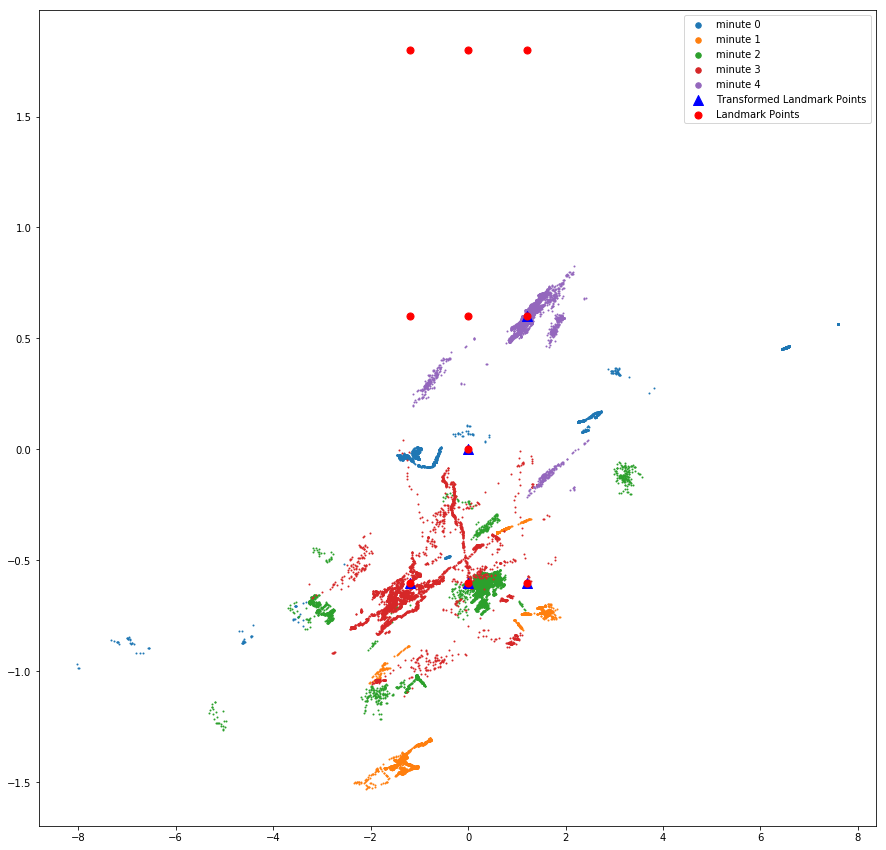

In [367]:
# plot d = 4
fig = plt.figure(figsize= (15,15))
ax = fig.add_subplot(111)
ind0 = 0
for i in range(N):
    ind1 = ind0 + minute_arrays[i].shape[0]
    lbl_string = 'minute ' + str(i)
    ax.scatter(projected_mat[0,ind0:ind1],projected_mat[1,ind0:ind1],s=1, label = lbl_string)
    ind0 = ind1
    
ax.scatter(transformed_mean_points[0,:],transformed_mean_points[1,:],s=100,c="b", marker = '^', label = 'Transformed Landmark Points')
ax.scatter(R[:,0], R[:,1],s = 50, c = 'r', label = 'Landmark Points')
for i in range(5):
    ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')
lgnd = ax.legend();
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
lgnd.legendHandles[4]._sizes = [30]

# for i in range(N):
#     ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')

# ax.scatter(R[:,0], R[:,1],s = 100, c = 'r', label='Landmark points')
# for i in range(10):
#     ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')
# ax.set_title('Picture in room coordinates (4 eigenvectors used)')
# ax.legend();

### Training with 10 points

In [379]:
# Calibrated recording timestamp within each minute (based on array 5)
calibrated_time = [['05','41'],
                   ['00','40'],
                   ['01','40'],
                   ['01','38'],
                   ['01','40'],
                   ['04','42'],
                   ['03','44'],
                   ['01','40'],
                   ['01','40'],
                   ['01','40']]
# 10 points are extracted
experiment_data = get_time_interval_matrix_data('Sep 30 2020 11:10AM', 'Sep 30 2020 11:20AM')
experiment_cdata = get_cdata(experiment_data)

d = 2
proj_exp_data = project_to_eigen_vectors(experiment_cdata, d, eigen_values_2930, eigen_vectors_2930)

minute_arrays = [] 
for i in range(0,10): # where i is minute
    one_minute_data = extractMinuteData(i,calibrated_time)
    minute_arrays.append(one_minute_data)
    
minute_mean_array_np = np.asarray([find_center_kmeans(data) for data in minute_arrays])

/home/ardelalegre/SoundMapping/Analysis/Util/PCA.py:44: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data[:,1:],axis = 0,keepdims = True)


In [380]:
N = 10
part_W = minute_mean_array_np.T
ones = np.asarray([1.0 for i in range(N)])
W = np.vstack((part_W, ones))

# Model X
model_a_Y = R[:N,0]
model_a_Y = np.reshape(model_a_Y,(N,1))
model_a_X = W.T
param_x = np.dot(np.dot(np.linalg.inv(np.dot(model_a_X.T, model_a_X)), model_a_X.T), model_a_Y)

# Model Y
model_a_Y_2 = R[:N,1]
model_a_Y_2 = np.reshape(model_a_Y_2,(N,1))
model_a_X = W.T
param_y = np.dot(np.dot(np.linalg.inv(np.dot(model_a_X.T, model_a_X)), model_a_X.T), model_a_Y_2)

G = np.stack((param_x.T, param_y.T))
G = np.reshape(G, (2, d+1))

all_data_np = np.vstack(minute_arrays)
# append column of 1's to relevant data
one_long = np.ones((all_data_np.shape[0],1))
to_project_mat = np.hstack((all_data_np, one_long))
to_project_mat_correct_orientation = to_project_mat.T
projected_mat = G @ to_project_mat_correct_orientation

In [381]:
transformed_mean_points = G @ model_a_X.T

In [382]:
projected_mat.shape

(2, 49973)

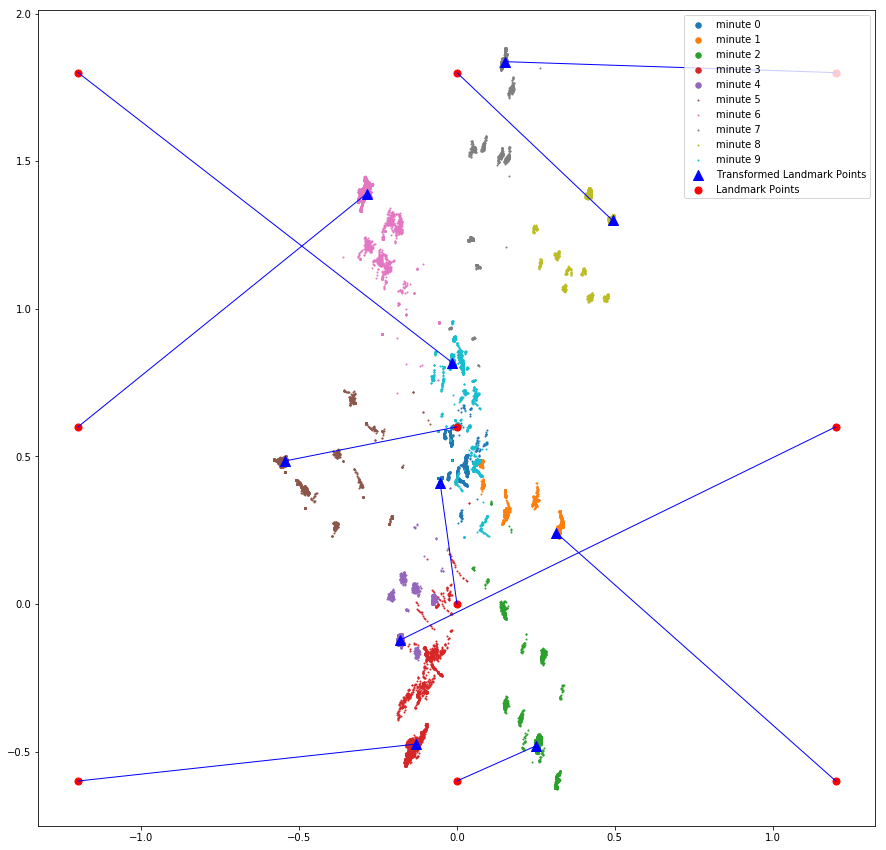

In [383]:
# plot d = 4
fig = plt.figure(figsize= (15,15))
ax = fig.add_subplot(111)
ind0 = 0
for i in range(N):
    ind1 = ind0 + minute_arrays[i].shape[0]
    lbl_string = 'minute ' + str(i)
    ax.scatter(projected_mat[0,ind0:ind1],projected_mat[1,ind0:ind1],s=1, label = lbl_string)
    ind0 = ind1
    
ax.scatter(transformed_mean_points[0,:],transformed_mean_points[1,:],s=100,c="b", marker = '^', label = 'Transformed Landmark Points')
ax.scatter(R[:,0], R[:,1],s = 50, c = 'r', label = 'Landmark Points')
for i in range(N):
    ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')
lgnd = ax.legend();
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
lgnd.legendHandles[4]._sizes = [30]

# for i in range(N):
#     ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')

# ax.scatter(R[:,0], R[:,1],s = 100, c = 'r', label='Landmark points')
# for i in range(10):
#     ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')
# ax.set_title('Picture in room coordinates (4 eigenvectors used)')
# ax.legend();

In [ ]:
# Look at one second of measurement
# Average of a second
# Plot the average of 1 second 